# User Latent Dirichlet Allocation

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
sys.path.append(os.path.abspath('../../vae_playground'))
sys.path.append(os.path.abspath('..'))

In [2]:
%load_ext autoreload
%autoreload 2

from lib.models import NeuralLDA as NeuralLDA

from sklearn.cluster import KMeans

import vae_playground.datasets as datasets

Import Data

In [3]:
DATASET_NAME = 'goi4_dp_small'
RANDOM_SEED = 2112
np.random.seed(RANDOM_SEED)

In [4]:
df = pd.read_csv(f'../data/{DATASET_NAME}/dataset.csv')
data, dates, users = df.iloc[:,:-2].values, df.date.values, df.user.values
date_ids, user_ids = df.date.unique(), df.user.unique()
num_days, num_users = len(date_ids), len(user_ids)
print(f'Loaded {len(data)} consumption profiles from {num_days} dates and {num_users} users')

Loaded 631815 consumption profiles from 365 dates and 1731 users


In [5]:
RESOLUTION = 1 #in hours

if RESOLUTION == 12:
    X = torch.tensor(data, dtype=torch.float32).reshape(-1, 24)
    #circle shift the last dimension of X
    X = torch.cat([X[:,6:], X[:,:6]], dim=-1).reshape(num_users, num_days, int(24/RESOLUTION), int(RESOLUTION)).sum(dim=-1)
else:
    X = torch.tensor(data, dtype=torch.float32).reshape(num_users, num_days, int(24/RESOLUTION), int(RESOLUTION)).sum(dim=-1)
dates, users = np.reshape(dates, (num_users, num_days)), np.reshape(users, (num_users, num_days))

In [6]:
# Remove users with all-zero consumption profiles
nonzero_user_mask = torch.sum(torch.all(X == 0, dim=2), dim=1) < num_days
print(f'Removing {(~nonzero_user_mask).sum()} users with all-zero consumption profiles')
positive_user_mask = torch.sum(torch.any(X < 0, dim=2), dim=1) == 0
print(f'Removing {(~positive_user_mask).sum()} users with any-negative consumption profiles')
user_mask = nonzero_user_mask & positive_user_mask

Removing 4 users with all-zero consumption profiles
Removing 18 users with any-negative consumption profiles


In [7]:
X = X[user_mask]
dates, users = dates[user_mask], users[user_mask]
user_ids = user_ids[user_mask]

In [8]:
USER_SUBSAMPLE_RATE = 1
DAY_SUBSAMPLE_RATE = 1
X = X[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :]
num_users, num_days, num_features = X.shape
X = X.flatten(end_dim=1)
print(f"Number of (subsampled/filtered) users: {num_users}")
print(f"Number of (subsampled) days: {num_days}")
print(f"Number of (aggregated) features: {num_features}")

Number of (subsampled/filtered) users: 1709
Number of (subsampled) days: 365
Number of (aggregated) features: 24


In [9]:
nonzero_mean, nonzero_std = datasets.zero_preserved_log_stats(X)
X_norm = datasets.zero_preserved_log_normalize(X, nonzero_mean, nonzero_std).reshape(num_users, num_days, num_features)
dataset = datasets.UserDayDataset(X_norm)
X_flt = dataset.flatten_inputs
user_idx, day_idx = dataset.user_day_list[:,0], dataset.user_day_list[:,1]

In [10]:
df_plt = pd.DataFrame(torch.cat((X_flt, user_idx.unsqueeze(1), day_idx.unsqueeze(1)), dim=-1))
df_plt.columns = [f'feature_{i}' for i in range(num_features)] + ['user'] + ['day']

In [11]:
if num_users <= 100 and num_features == 2:
    sns.scatterplot(df_plt, x="feature_0", y="feature_1", hue='user', palette="Set1", alpha=.5)
    # move the legend outside
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='user', ncol=5)
    plt.xlabel('Diurnal consumption')
    plt.ylabel('Nocturnal consumption')
    plt.show()

In [12]:
n_bins = 100
kmeans = KMeans(n_clusters=n_bins, random_state=RANDOM_SEED, n_init='auto').fit(X_flt)

In [13]:
labels = kmeans.labels_
labels_onehot = np.zeros((len(labels), len(set(labels))))
labels_onehot[np.arange(len(labels)), labels] = 1
X_words = torch.tensor(labels_onehot).reshape(num_users, num_days, -1)

In [14]:
DOC_TYPE = "day"       # "day" or "user"

if DOC_TYPE == "day":
    X_document = X_words.sum(dim=0)
elif DOC_TYPE == "user":
    X_document = X_words.sum(dim=1)
else:
    raise ValueError(f"Invalid DOC_TYPE: {DOC_TYPE}")

num_docs, num_words = X_document.shape

In [15]:
if n_bins <= 50 and num_features == 2:
    df_plt = pd.DataFrame(torch.cat((X_flt,torch.tensor(labels).unsqueeze(1)), dim=-1))
    df_plt.columns = [f'feature_{i}' for i in range(num_features)] + ['word']
    sns.scatterplot(df_plt, x="feature_0", y="feature_1", hue='word', palette="Set2", alpha=.5)
    plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='x', s=100, c='black')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='word_id', ncol=5)
    plt.xlabel('Diurnal consumption')
    plt.ylabel('Nocturnal consumption')
    plt.show()

In [16]:
X_labels = torch.tensor(labels).reshape(num_users, num_days)
if DOC_TYPE == "day": X_labels = X_labels.T

In [17]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X): self.X = X
    def __len__(self): return len(self.X)
    def __getitem__(self, index): return self.X[index]

In [18]:
dataset = Dataset(X_document.to(torch.float32))

In [31]:
# Set training parameters.
num_topics = 10
prodlda = False
conv = False
num_layers = 2
num_neurons = 200

In [32]:
model = NeuralLDA(input_dim=n_bins,
                    num_topics=num_topics, 
                    conv=conv,
                    prodlda=prodlda,
                    num_hidden_layers=num_layers,
                    num_neurons=num_neurons,
                    )

In [33]:
lr = 1e-3
batch_size = 32
num_epochs = 1000
beta = 1
learn_prior = False
prior_params = {'alpha': 1.0}

In [34]:
# Train the model using default partitioning choice 
model.train(lr=lr,
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True),
            num_epochs = num_epochs,
            beta = beta,
            prior_params = prior_params,
            mc_samples = 1,
            learn_prior = learn_prior,
            tensorboard = False,
            )

Epoch:   1%|          | 10/1000 [00:01<02:03,  7.99it/s]  

Iteration: 100 -- ELBO=-7.84e+03 / RLL=-7.82e+03 / KL=1.36e+01


Epoch:   2%|▏         | 20/1000 [00:02<01:36, 10.19it/s]  

Iteration: 200 -- ELBO=-7.74e+03 / RLL=-7.73e+03 / KL=1.52e+01


Epoch:   3%|▎         | 28/1000 [00:02<01:10, 13.72it/s]  

Iteration: 300 -- ELBO=-7.68e+03 / RLL=-7.66e+03 / KL=1.68e+01


Epoch:   4%|▎         | 36/1000 [00:03<01:03, 15.18it/s]  

Iteration: 400 -- ELBO=-7.57e+03 / RLL=-7.55e+03 / KL=1.80e+01


Epoch:   5%|▍         | 46/1000 [00:03<01:01, 15.45it/s]  

Iteration: 500 -- ELBO=-7.55e+03 / RLL=-7.53e+03 / KL=1.92e+01


Epoch:   5%|▌         | 54/1000 [00:04<01:13, 12.90it/s]  

Iteration: 600 -- ELBO=-7.49e+03 / RLL=-7.47e+03 / KL=2.00e+01


Epoch:   6%|▌         | 62/1000 [00:05<01:03, 14.84it/s]  

Iteration: 700 -- ELBO=-7.45e+03 / RLL=-7.42e+03 / KL=2.08e+01


Epoch:   7%|▋         | 70/1000 [00:05<00:56, 16.52it/s]  

Iteration: 800 -- ELBO=-7.45e+03 / RLL=-7.43e+03 / KL=2.13e+01


Epoch:   8%|▊         | 78/1000 [00:06<00:55, 16.64it/s]  

Iteration: 900 -- ELBO=-7.40e+03 / RLL=-7.38e+03 / KL=2.18e+01


Epoch:   9%|▊         | 86/1000 [00:06<00:53, 17.12it/s]  

Iteration: 1000 -- ELBO=-7.39e+03 / RLL=-7.37e+03 / KL=2.21e+01


Epoch:  10%|▉         | 96/1000 [00:07<00:53, 16.94it/s]  


Iteration: 1100 -- ELBO=-7.35e+03 / RLL=-7.32e+03 / KL=2.24e+01


Epoch:  10%|█         | 104/1000 [00:07<00:53, 16.88it/s] 

Iteration: 1200 -- ELBO=-7.33e+03 / RLL=-7.31e+03 / KL=2.26e+01


Epoch:  11%|█         | 110/1000 [00:08<01:02, 14.19it/s] 

Iteration: 1300 -- ELBO=-7.34e+03 / RLL=-7.31e+03 / KL=2.28e+01


Epoch:  12%|█▏        | 120/1000 [00:09<01:22, 10.71it/s] 

Iteration: 1400 -- ELBO=-7.33e+03 / RLL=-7.30e+03 / KL=2.28e+01


Epoch:  13%|█▎        | 128/1000 [00:09<01:00, 14.40it/s] 

Iteration: 1500 -- ELBO=-7.26e+03 / RLL=-7.24e+03 / KL=2.30e+01


Epoch:  14%|█▎        | 136/1000 [00:10<00:56, 15.27it/s] 

Iteration: 1600 -- ELBO=-7.33e+03 / RLL=-7.31e+03 / KL=2.30e+01


Epoch:  15%|█▍        | 146/1000 [00:10<00:51, 16.70it/s] 

Iteration: 1700 -- ELBO=-7.31e+03 / RLL=-7.28e+03 / KL=2.26e+01


Epoch:  15%|█▌        | 154/1000 [00:11<00:49, 17.26it/s] 

Iteration: 1800 -- ELBO=-7.30e+03 / RLL=-7.28e+03 / KL=2.30e+01


Epoch:  16%|█▌        | 162/1000 [00:11<00:46, 17.99it/s] 

Iteration: 1900 -- ELBO=-7.28e+03 / RLL=-7.26e+03 / KL=2.29e+01


Epoch:  17%|█▋        | 170/1000 [00:12<00:54, 15.09it/s] 

Iteration: 2000 -- ELBO=-7.28e+03 / RLL=-7.26e+03 / KL=2.29e+01


Epoch:  18%|█▊        | 178/1000 [00:12<00:51, 16.07it/s] 

Iteration: 2100 -- ELBO=-7.33e+03 / RLL=-7.31e+03 / KL=2.25e+01


Epoch:  18%|█▊        | 184/1000 [00:13<01:52,  7.25it/s] 

Iteration: 2200 -- ELBO=-7.22e+03 / RLL=-7.20e+03 / KL=2.25e+01


Epoch:  19%|█▉        | 194/1000 [00:15<01:22,  9.71it/s] 

Iteration: 2300 -- ELBO=-7.25e+03 / RLL=-7.23e+03 / KL=2.21e+01


Epoch:  20%|██        | 204/1000 [00:15<00:53, 14.76it/s] 

Iteration: 2400 -- ELBO=-7.24e+03 / RLL=-7.22e+03 / KL=2.22e+01


Epoch:  21%|██        | 212/1000 [00:16<00:58, 13.49it/s] 

Iteration: 2500 -- ELBO=-7.33e+03 / RLL=-7.31e+03 / KL=2.14e+01


Epoch:  22%|██▏       | 220/1000 [00:16<00:50, 15.53it/s] 

Iteration: 2600 -- ELBO=-7.27e+03 / RLL=-7.25e+03 / KL=2.17e+01


Epoch:  23%|██▎       | 228/1000 [00:17<00:48, 16.03it/s] 

Iteration: 2700 -- ELBO=-7.23e+03 / RLL=-7.21e+03 / KL=2.18e+01


Epoch:  24%|██▎       | 236/1000 [00:17<00:47, 16.13it/s] 

Iteration: 2800 -- ELBO=-7.26e+03 / RLL=-7.24e+03 / KL=2.15e+01


Epoch:  24%|██▍       | 244/1000 [00:18<00:46, 16.20it/s] 

Iteration: 2900 -- ELBO=-7.23e+03 / RLL=-7.21e+03 / KL=2.15e+01


Epoch:  25%|██▌       | 252/1000 [00:19<01:04, 11.56it/s]          

Iteration: 3000 -- ELBO=-7.28e+03 / RLL=-7.26e+03 / KL=2.11e+01


Epoch:  26%|██▌       | 262/1000 [00:19<00:49, 14.94it/s] 

Iteration: 3100 -- ELBO=-7.25e+03 / RLL=-7.22e+03 / KL=2.11e+01


Epoch:  27%|██▋       | 268/1000 [00:20<00:47, 15.31it/s] 

Iteration: 3200 -- ELBO=-7.26e+03 / RLL=-7.24e+03 / KL=2.08e+01


Epoch:  28%|██▊       | 278/1000 [00:20<00:50, 14.37it/s] 

Iteration: 3300 -- ELBO=-7.26e+03 / RLL=-7.24e+03 / KL=2.12e+01


Epoch:  29%|██▊       | 286/1000 [00:22<01:13,  9.69it/s] 

Iteration: 3400 -- ELBO=-7.26e+03 / RLL=-7.24e+03 / KL=2.03e+01


Epoch:  30%|██▉       | 296/1000 [00:22<00:47, 14.92it/s] 


Iteration: 3500 -- ELBO=-7.24e+03 / RLL=-7.22e+03 / KL=2.05e+01


Epoch:  30%|███       | 304/1000 [00:23<00:42, 16.23it/s] 

Iteration: 3600 -- ELBO=-7.29e+03 / RLL=-7.27e+03 / KL=2.05e+01


Epoch:  31%|███       | 312/1000 [00:23<00:40, 16.84it/s] 

Iteration: 3700 -- ELBO=-7.33e+03 / RLL=-7.31e+03 / KL=1.97e+01


Epoch:  32%|███▏      | 320/1000 [00:24<00:39, 17.32it/s]

Iteration: 3800 -- ELBO=-7.30e+03 / RLL=-7.28e+03 / KL=2.03e+01


Epoch:  33%|███▎      | 328/1000 [00:24<00:39, 17.08it/s] 

Iteration: 3900 -- ELBO=-7.16e+03 / RLL=-7.14e+03 / KL=2.05e+01


Epoch:  34%|███▎      | 336/1000 [00:24<00:39, 16.98it/s] 

Iteration: 4000 -- ELBO=-7.28e+03 / RLL=-7.26e+03 / KL=1.96e+01


Epoch:  34%|███▍      | 344/1000 [00:25<00:40, 16.05it/s] 

Iteration: 4100 -- ELBO=-7.23e+03 / RLL=-7.21e+03 / KL=1.97e+01


Epoch:  35%|███▌      | 354/1000 [00:26<00:40, 15.96it/s] 

Iteration: 4200 -- ELBO=-7.29e+03 / RLL=-7.27e+03 / KL=1.99e+01


Epoch:  36%|███▌      | 362/1000 [00:26<00:40, 15.88it/s] 

Iteration: 4300 -- ELBO=-7.23e+03 / RLL=-7.21e+03 / KL=1.99e+01


Epoch:  37%|███▋      | 370/1000 [00:27<00:39, 15.93it/s] 

Iteration: 4400 -- ELBO=-7.24e+03 / RLL=-7.22e+03 / KL=1.94e+01


Epoch:  38%|███▊      | 378/1000 [00:27<00:39, 15.89it/s] 

Iteration: 4500 -- ELBO=-7.28e+03 / RLL=-7.26e+03 / KL=1.98e+01


Epoch:  39%|███▊      | 386/1000 [00:28<00:38, 16.03it/s] 

Iteration: 4600 -- ELBO=-7.28e+03 / RLL=-7.26e+03 / KL=1.92e+01


Epoch:  39%|███▉      | 394/1000 [00:28<00:43, 13.93it/s] 

Iteration: 4700 -- ELBO=-7.24e+03 / RLL=-7.22e+03 / KL=1.92e+01


Epoch:  40%|████      | 404/1000 [00:29<00:36, 16.32it/s] 

Iteration: 4800 -- ELBO=-7.28e+03 / RLL=-7.26e+03 / KL=1.97e+01


Epoch:  41%|████      | 412/1000 [00:29<00:36, 16.29it/s] 

Iteration: 4900 -- ELBO=-7.25e+03 / RLL=-7.24e+03 / KL=1.86e+01


Epoch:  42%|████▏     | 420/1000 [00:30<00:37, 15.66it/s] 

Iteration: 5000 -- ELBO=-7.27e+03 / RLL=-7.25e+03 / KL=1.87e+01


Epoch:  43%|████▎     | 428/1000 [00:30<00:35, 15.93it/s] 

Iteration: 5100 -- ELBO=-7.34e+03 / RLL=-7.32e+03 / KL=1.88e+01


Epoch:  44%|████▎     | 436/1000 [00:31<00:34, 16.14it/s] 

Iteration: 5200 -- ELBO=-7.24e+03 / RLL=-7.22e+03 / KL=1.88e+01


Epoch:  45%|████▍     | 446/1000 [00:31<00:32, 17.00it/s] 

Iteration: 5300 -- ELBO=-7.25e+03 / RLL=-7.23e+03 / KL=1.88e+01


Epoch:  45%|████▌     | 454/1000 [00:32<00:31, 17.11it/s] 

Iteration: 5400 -- ELBO=-7.35e+03 / RLL=-7.33e+03 / KL=1.80e+01


Epoch:  46%|████▌     | 462/1000 [00:32<00:30, 17.68it/s] 


Iteration: 5500 -- ELBO=-7.25e+03 / RLL=-7.23e+03 / KL=1.88e+01


Epoch:  47%|████▋     | 470/1000 [00:33<00:31, 16.79it/s] 

Iteration: 5600 -- ELBO=-7.28e+03 / RLL=-7.26e+03 / KL=1.84e+01


Epoch:  48%|████▊     | 478/1000 [00:33<00:31, 16.61it/s] 

Iteration: 5700 -- ELBO=-7.27e+03 / RLL=-7.25e+03 / KL=1.88e+01


Epoch:  49%|████▊     | 486/1000 [00:34<00:32, 15.63it/s] 

Iteration: 5800 -- ELBO=-7.27e+03 / RLL=-7.25e+03 / KL=1.83e+01


Epoch:  49%|████▉     | 494/1000 [00:34<00:32, 15.70it/s] 

Iteration: 5900 -- ELBO=-7.28e+03 / RLL=-7.26e+03 / KL=1.86e+01


Epoch:  50%|█████     | 504/1000 [00:35<00:31, 15.98it/s] 

Iteration: 6000 -- ELBO=-7.26e+03 / RLL=-7.24e+03 / KL=1.86e+01


Epoch:  51%|█████     | 512/1000 [00:35<00:29, 16.79it/s]

Iteration: 6100 -- ELBO=-7.21e+03 / RLL=-7.20e+03 / KL=1.85e+01


Epoch:  52%|█████▏    | 520/1000 [00:36<00:28, 17.06it/s] 

Iteration: 6200 -- ELBO=-7.30e+03 / RLL=-7.29e+03 / KL=1.79e+01


Epoch:  53%|█████▎    | 528/1000 [00:36<00:29, 16.26it/s] 

Iteration: 6300 -- ELBO=-7.17e+03 / RLL=-7.16e+03 / KL=1.82e+01


Epoch:  54%|█████▎    | 536/1000 [00:37<00:27, 16.60it/s] 

Iteration: 6400 -- ELBO=-7.25e+03 / RLL=-7.23e+03 / KL=1.80e+01


Epoch:  54%|█████▍    | 544/1000 [00:37<00:28, 16.25it/s] 

Iteration: 6500 -- ELBO=-7.22e+03 / RLL=-7.20e+03 / KL=1.82e+01


Epoch:  55%|█████▌    | 554/1000 [00:38<00:27, 16.28it/s] 

Iteration: 6600 -- ELBO=-7.19e+03 / RLL=-7.17e+03 / KL=1.82e+01


Epoch:  56%|█████▌    | 562/1000 [00:38<00:26, 16.26it/s] 

Iteration: 6700 -- ELBO=-7.22e+03 / RLL=-7.20e+03 / KL=1.85e+01


Epoch:  57%|█████▋    | 570/1000 [00:39<00:26, 16.06it/s] 

Iteration: 6800 -- ELBO=-7.20e+03 / RLL=-7.18e+03 / KL=1.83e+01


Epoch:  58%|█████▊    | 578/1000 [00:39<00:26, 15.81it/s] 

Iteration: 6900 -- ELBO=-7.29e+03 / RLL=-7.27e+03 / KL=1.83e+01


Epoch:  59%|█████▊    | 586/1000 [00:40<00:26, 15.72it/s] 

Iteration: 7000 -- ELBO=-7.30e+03 / RLL=-7.28e+03 / KL=1.77e+01


Epoch:  59%|█████▉    | 594/1000 [00:41<00:25, 15.70it/s] 

Iteration: 7100 -- ELBO=-7.19e+03 / RLL=-7.17e+03 / KL=1.83e+01


Epoch:  60%|██████    | 604/1000 [00:41<00:23, 16.61it/s] 

Iteration: 7200 -- ELBO=-7.25e+03 / RLL=-7.23e+03 / KL=1.79e+01


Epoch:  61%|██████    | 612/1000 [00:42<00:23, 16.83it/s] 

Iteration: 7300 -- ELBO=-7.27e+03 / RLL=-7.25e+03 / KL=1.78e+01


Epoch:  62%|██████▏   | 620/1000 [00:42<00:22, 16.82it/s] 

Iteration: 7400 -- ELBO=-7.23e+03 / RLL=-7.21e+03 / KL=1.79e+01


Epoch:  63%|██████▎   | 628/1000 [00:43<00:21, 16.95it/s] 

Iteration: 7500 -- ELBO=-7.29e+03 / RLL=-7.27e+03 / KL=1.70e+01


Epoch:  64%|██████▎   | 636/1000 [00:43<00:21, 16.82it/s] 

Iteration: 7600 -- ELBO=-7.14e+03 / RLL=-7.13e+03 / KL=1.77e+01


Epoch:  64%|██████▍   | 644/1000 [00:43<00:21, 16.50it/s] 

Iteration: 7700 -- ELBO=-7.27e+03 / RLL=-7.25e+03 / KL=1.81e+01


Epoch:  65%|██████▌   | 654/1000 [00:44<00:20, 16.93it/s] 

Iteration: 7800 -- ELBO=-7.25e+03 / RLL=-7.23e+03 / KL=1.78e+01


Epoch:  66%|██████▌   | 662/1000 [00:45<00:20, 16.84it/s] 

Iteration: 7900 -- ELBO=-7.17e+03 / RLL=-7.16e+03 / KL=1.79e+01


Epoch:  67%|██████▋   | 670/1000 [00:45<00:19, 17.02it/s] 

Iteration: 8000 -- ELBO=-7.24e+03 / RLL=-7.22e+03 / KL=1.77e+01


Epoch:  68%|██████▊   | 678/1000 [00:46<00:18, 17.03it/s] 

Iteration: 8100 -- ELBO=-7.25e+03 / RLL=-7.24e+03 / KL=1.77e+01


Epoch:  69%|██████▊   | 686/1000 [00:46<00:22, 13.97it/s] 

Iteration: 8200 -- ELBO=-7.23e+03 / RLL=-7.21e+03 / KL=1.75e+01


Epoch:  69%|██████▉   | 694/1000 [00:47<00:19, 15.83it/s] 

Iteration: 8300 -- ELBO=-7.27e+03 / RLL=-7.25e+03 / KL=1.67e+01


Epoch:  70%|███████   | 704/1000 [00:47<00:18, 16.02it/s] 

Iteration: 8400 -- ELBO=-7.30e+03 / RLL=-7.28e+03 / KL=1.71e+01


Epoch:  71%|███████   | 712/1000 [00:48<00:17, 16.03it/s] 

Iteration: 8500 -- ELBO=-7.23e+03 / RLL=-7.21e+03 / KL=1.75e+01


Epoch:  72%|███████▏  | 720/1000 [00:48<00:17, 15.94it/s] 

Iteration: 8600 -- ELBO=-7.27e+03 / RLL=-7.26e+03 / KL=1.75e+01


Epoch:  73%|███████▎  | 728/1000 [00:49<00:17, 15.76it/s] 

Iteration: 8700 -- ELBO=-7.16e+03 / RLL=-7.14e+03 / KL=1.76e+01


Epoch:  74%|███████▎  | 736/1000 [00:49<00:16, 15.69it/s] 

Iteration: 8800 -- ELBO=-7.21e+03 / RLL=-7.20e+03 / KL=1.71e+01


Epoch:  75%|███████▍  | 746/1000 [00:50<00:15, 16.60it/s] 

Iteration: 8900 -- ELBO=-7.21e+03 / RLL=-7.19e+03 / KL=1.71e+01


Epoch:  75%|███████▌  | 754/1000 [00:50<00:14, 16.90it/s] 

Iteration: 9000 -- ELBO=-7.30e+03 / RLL=-7.29e+03 / KL=1.74e+01


Epoch:  76%|███████▌  | 762/1000 [00:51<00:14, 16.68it/s] 

Iteration: 9100 -- ELBO=-7.21e+03 / RLL=-7.20e+03 / KL=1.71e+01


Epoch:  77%|███████▋  | 770/1000 [00:51<00:14, 16.01it/s] 

Iteration: 9200 -- ELBO=-7.20e+03 / RLL=-7.18e+03 / KL=1.73e+01


Epoch:  78%|███████▊  | 778/1000 [00:52<00:13, 15.99it/s] 

Iteration: 9300 -- ELBO=-7.20e+03 / RLL=-7.19e+03 / KL=1.68e+01


Epoch:  79%|███████▊  | 786/1000 [00:52<00:13, 15.59it/s] 

Iteration: 9400 -- ELBO=-7.20e+03 / RLL=-7.18e+03 / KL=1.70e+01


Epoch:  79%|███████▉  | 794/1000 [00:53<00:13, 15.64it/s] 

Iteration: 9500 -- ELBO=-7.22e+03 / RLL=-7.20e+03 / KL=1.74e+01


Epoch:  80%|████████  | 804/1000 [00:53<00:12, 16.26it/s] 

Iteration: 9600 -- ELBO=-7.15e+03 / RLL=-7.14e+03 / KL=1.68e+01


Epoch:  81%|████████  | 812/1000 [00:54<00:11, 15.92it/s] 

Iteration: 9700 -- ELBO=-7.23e+03 / RLL=-7.21e+03 / KL=1.71e+01


Epoch:  82%|████████▏ | 820/1000 [00:55<00:11, 15.93it/s] 

Iteration: 9800 -- ELBO=-7.23e+03 / RLL=-7.21e+03 / KL=1.69e+01


Epoch:  83%|████████▎ | 828/1000 [00:55<00:10, 15.70it/s] 

Iteration: 9900 -- ELBO=-7.21e+03 / RLL=-7.19e+03 / KL=1.72e+01


Epoch:  84%|████████▎ | 836/1000 [00:56<00:10, 15.55it/s] 

Iteration: 10000 -- ELBO=-7.20e+03 / RLL=-7.18e+03 / KL=1.75e+01


Epoch:  84%|████████▍ | 844/1000 [00:56<00:09, 15.69it/s] 

Iteration: 10100 -- ELBO=-7.25e+03 / RLL=-7.23e+03 / KL=1.72e+01


Epoch:  85%|████████▌ | 854/1000 [00:57<00:09, 16.00it/s] 

Iteration: 10200 -- ELBO=-7.18e+03 / RLL=-7.16e+03 / KL=1.74e+01


Epoch:  86%|████████▌ | 862/1000 [00:57<00:08, 15.91it/s] 

Iteration: 10300 -- ELBO=-7.19e+03 / RLL=-7.17e+03 / KL=1.72e+01


Epoch:  87%|████████▋ | 870/1000 [00:58<00:08, 16.00it/s] 

Iteration: 10400 -- ELBO=-7.25e+03 / RLL=-7.23e+03 / KL=1.71e+01


Epoch:  88%|████████▊ | 878/1000 [00:58<00:07, 16.07it/s] 

Iteration: 10500 -- ELBO=-7.22e+03 / RLL=-7.20e+03 / KL=1.80e+01


Epoch:  89%|████████▊ | 886/1000 [00:59<00:07, 15.60it/s] 

Iteration: 10600 -- ELBO=-7.26e+03 / RLL=-7.24e+03 / KL=1.73e+01


Epoch:  90%|████████▉ | 896/1000 [00:59<00:06, 16.17it/s] 


Iteration: 10700 -- ELBO=-7.17e+03 / RLL=-7.15e+03 / KL=1.70e+01


Epoch:  90%|█████████ | 904/1000 [01:00<00:05, 16.10it/s] 

Iteration: 10800 -- ELBO=-7.33e+03 / RLL=-7.32e+03 / KL=1.68e+01


Epoch:  91%|█████████ | 912/1000 [01:00<00:05, 15.85it/s] 

Iteration: 10900 -- ELBO=-7.26e+03 / RLL=-7.24e+03 / KL=1.70e+01


Epoch:  92%|█████████▏| 920/1000 [01:01<00:04, 16.00it/s] 

Iteration: 11000 -- ELBO=-7.22e+03 / RLL=-7.20e+03 / KL=1.71e+01


Epoch:  93%|█████████▎| 928/1000 [01:01<00:04, 16.01it/s] 

Iteration: 11100 -- ELBO=-7.16e+03 / RLL=-7.14e+03 / KL=1.68e+01


Epoch:  94%|█████████▎| 936/1000 [01:02<00:03, 16.26it/s] 

Iteration: 11200 -- ELBO=-7.23e+03 / RLL=-7.22e+03 / KL=1.68e+01


Epoch:  95%|█████████▍| 946/1000 [01:02<00:03, 16.98it/s] 

Iteration: 11300 -- ELBO=-7.25e+03 / RLL=-7.23e+03 / KL=1.65e+01


Epoch:  95%|█████████▌| 954/1000 [01:03<00:02, 16.74it/s] 

Iteration: 11400 -- ELBO=-7.30e+03 / RLL=-7.28e+03 / KL=1.61e+01


Epoch:  96%|█████████▌| 962/1000 [01:03<00:02, 16.13it/s] 

Iteration: 11500 -- ELBO=-7.20e+03 / RLL=-7.18e+03 / KL=1.69e+01


Epoch:  97%|█████████▋| 970/1000 [01:04<00:01, 15.93it/s] 

Iteration: 11600 -- ELBO=-7.23e+03 / RLL=-7.22e+03 / KL=1.70e+01


Epoch:  98%|█████████▊| 978/1000 [01:04<00:01, 15.73it/s] 

Iteration: 11700 -- ELBO=-7.27e+03 / RLL=-7.25e+03 / KL=1.68e+01


Epoch:  99%|█████████▊| 986/1000 [01:05<00:00, 15.65it/s] 

Iteration: 11800 -- ELBO=-7.28e+03 / RLL=-7.27e+03 / KL=1.65e+01


Epoch: 100%|█████████▉| 996/1000 [01:06<00:00, 16.82it/s] 

Iteration: 11900 -- ELBO=-7.25e+03 / RLL=-7.23e+03 / KL=1.65e+01


Iteration in Epoch: 100%|██████████| 12/12 [00:00<00:00, 194.70it/s]

Iteration: 12000 -- ELBO=-7.26e+03 / RLL=-7.24e+03 / KL=1.72e+01


In [38]:
model.prior_params["alpha"]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [39]:
_, theta_dict = model(X_document.to(torch.float32), mc_samples=1000)
gamma_document_sample_mean = theta_dict['samples'].mean(dim=0).T.detach().numpy()

In [40]:
gamma_document_sample_mean[:,0]

array([0.03780634, 0.04182525, 0.03784651, 0.03818784, 0.08957909,
       0.23508343, 0.2303193 , 0.07271291, 0.17811307, 0.03852626],
      dtype=float32)

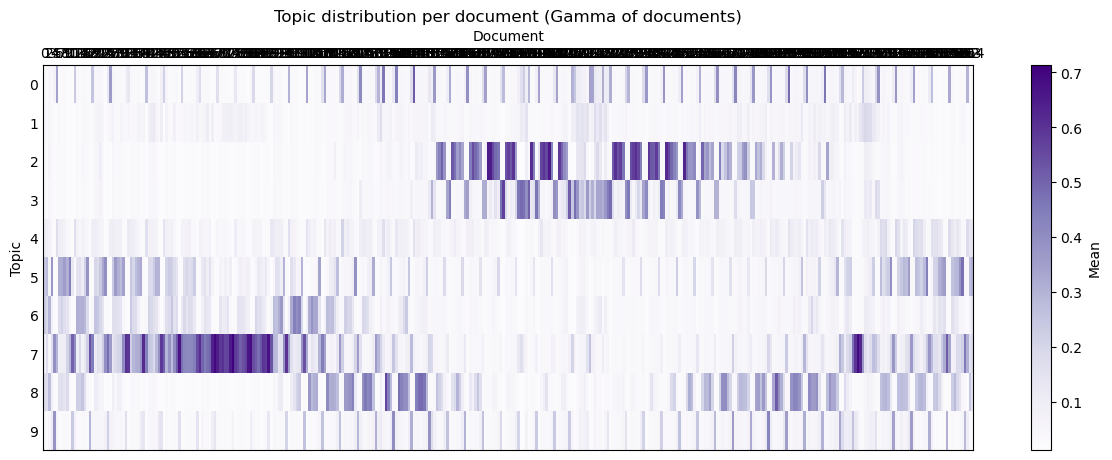

In [41]:
fig, ax = plt.subplots(figsize=(15,5))
im = ax.imshow(gamma_document_sample_mean, aspect='auto', cmap='Purples', interpolation='none')
ax.set_title('Topic distribution per document (Gamma of documents)')
ax.set_ylabel('Topic')
ax.set_xlabel('Document')
ax.set_yticks(np.arange(num_topics))
ax.set_xticks(np.arange(num_docs))
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
fig.colorbar(im, ax=ax, label='Mean')
plt.show()

In [42]:
gamma_document = theta_dict['params']['alpha'].detach().numpy().T

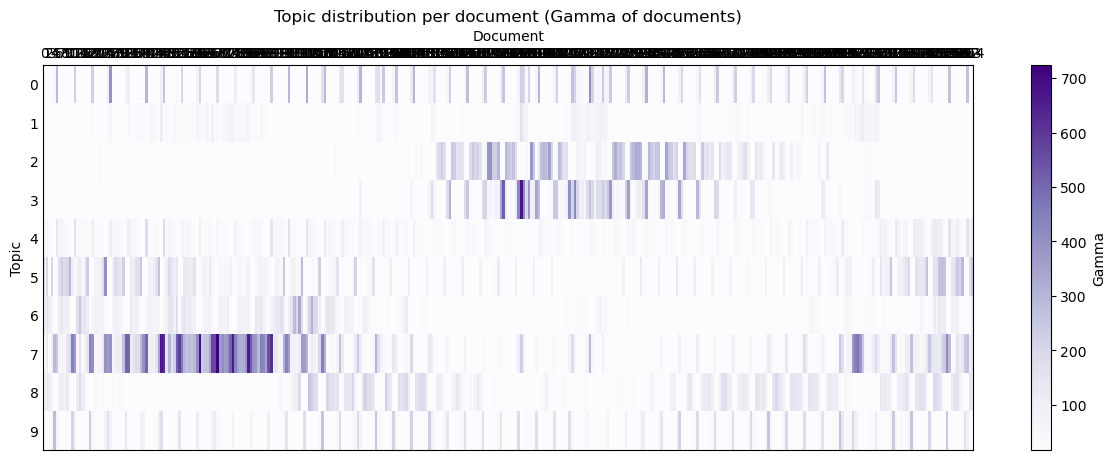

In [43]:
fig, ax = plt.subplots(figsize=(15,5))
im = ax.imshow(gamma_document, aspect='auto', cmap='Purples', interpolation='none')
ax.set_title('Topic distribution per document (Gamma of documents)')
ax.set_ylabel('Topic')
ax.set_xlabel('Document')
ax.set_yticks(np.arange(num_topics))
ax.set_xticks(np.arange(num_docs))
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
fig.colorbar(im, ax=ax, label='Gamma')
plt.show()

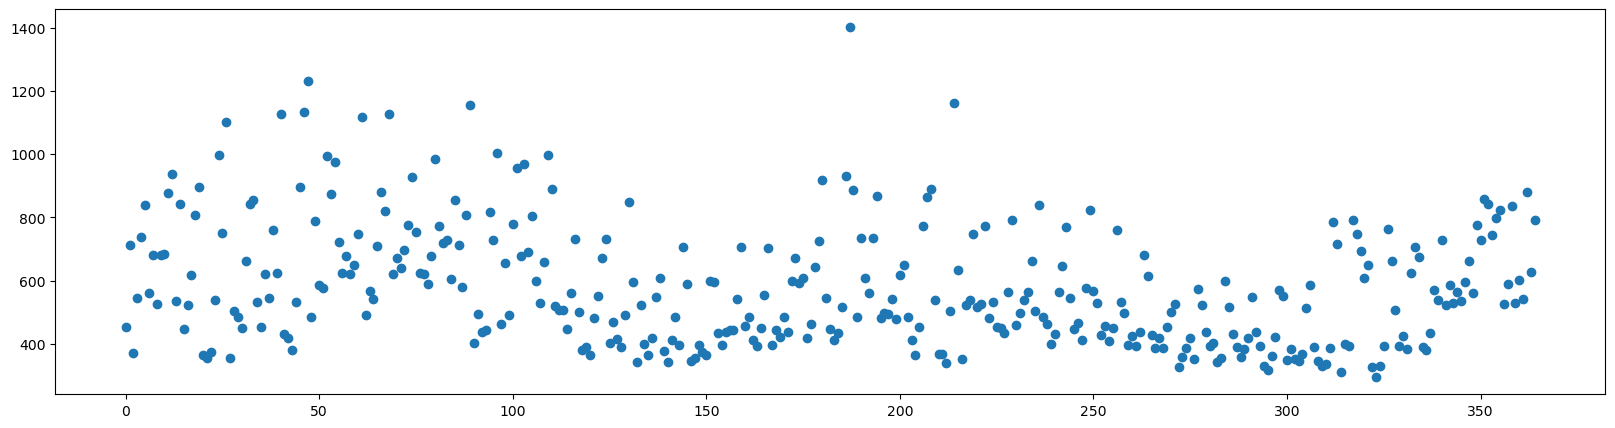

In [44]:
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(np.arange(num_days), gamma_document.sum(axis=0))

In [45]:
## entropy of dirichlet distribution
entropy = torch.distributions.dirichlet.Dirichlet(theta_dict['params']['alpha'].detach()).entropy()

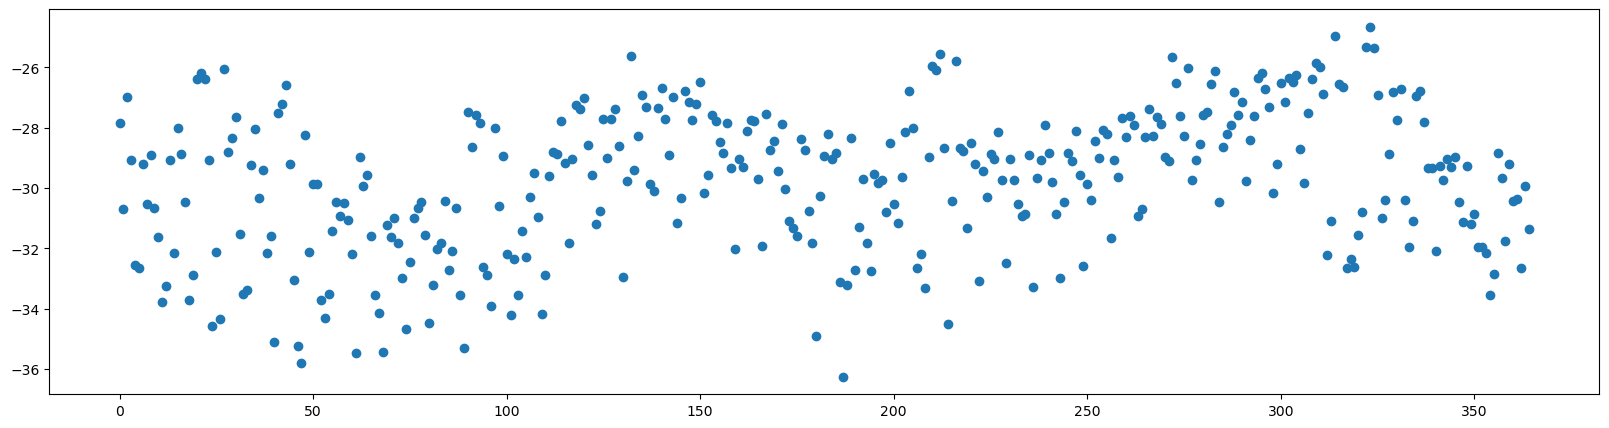

In [46]:
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(np.arange(num_days), entropy)

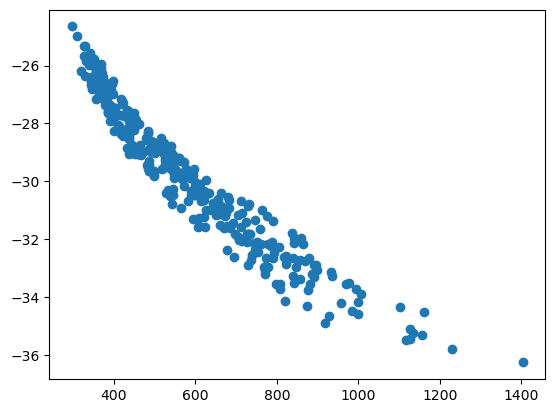

In [47]:
plt.scatter(gamma_document.sum(axis=0), entropy)